In [2]:
import torch
import torchvision
import os,  sys
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

In [2]:
# steps required: compute gfb outputs for all images, at once.
# compute covariance matrix from the gfb outputs.

In [3]:
bits_in_bytes = 8
precision = 32
channels = 64
resolution = (32,32)
bytes_in_gib = 2**30

pixels = np.prod(resolution)

sz = (channels * pixels)**2 * precision / bits_in_bytes / bytes_in_gib
print(sz, "GiB")

16.0 GiB


In [3]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

In [4]:
from vonenet.modules import GFB

/Users/metehergul/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
    
model = torchvision.models.resnet18(pretrained=False)

/Users/metehergul/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/metehergul/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [8]:
batch = 128
colour = 3
dim = 64
in_channels = colour
cc = 8
out_channels = 2 * cc
kernel_size = 13
padding = kernel_size // 2
stride = 2

# weight = torch.rand((out_channels, in_channels, kernel_size, kernel_size))
# res = F.conv2d(x, weight, None, stride, padding)

In [9]:
from vonenet.vonenet import VOneNet

In [10]:
visual_degrees = 2
k_exc = 7
# stride = 4
image_size=64

von = VOneNet(simple_channels=cc, model_arch="resnet18", complex_channels=cc, k_exc=k_exc, ksize=kernel_size, stride = stride, image_size=image_size, visual_degrees=visual_degrees, sf_min = 0.5, sf_max = 11.2)

Neuronal distributions gabor parameters
Model:  VOneResNet18
Number of classes:  200


/Users/metehergul/vonenet-mete/vonenet/params.py:59: RuntimeWarning: invalid value encountered in divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)
/Users/metehergul/Library/Python/3.9/lib/python/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
voneblock = von[0]

In [12]:
try:
    os.mkdir("runlog")
except:
    print("Directory already exists.")
    pass

Directory already exists.


In [13]:
import os, argparse, time, subprocess, io, shlex, pickle, pprint
import pandas as pd
import numpy as np
import tqdm
import fire

In [6]:
batch_size = 128
model_arch = "resnet18"
normalization = "vonenet"
visual_degrees = 2
stride = 2
ksize = 25
k_exc = 25
simple_channels = 8
complex_channels = simple_channels
image_size = 64
sf_min = 0
sf_max = 5.6


In [7]:
von = VOneNet(gabor_seed=0, simple_channels=simple_channels, complex_channels=complex_channels, model_arch="resnet18", noise_mode="None", k_exc=k_exc, ksize=ksize, stride = stride, image_size=image_size, visual_degrees=visual_degrees, sf_min = sf_min, sf_max = sf_max)
voneblock = von[0]
voneblock

NameError: name 'VOneNet' is not defined

In [234]:
voneblock.stride

2

In [235]:
# voneblock.simple_conv_q0.weight = nn.Parameter(F.interpolate(voneblock.simple_conv_q0.weight, size = (9,9)), requires_grad = False)
# voneblock.simple_conv_q1.weight = nn.Parameter(F.interpolate(voneblock.simple_conv_q1.weight, size = (9,9)), requires_grad = False)

# voneblock.ksize = 9

# voneblock.simple_conv_q0.padding = (voneblock.ksize//2, voneblock.ksize//2)
# voneblock.simple_conv_q1.padding = (voneblock.ksize//2, voneblock.ksize//2)

filters_r = voneblock.simple_conv_q0.weight
random_channel = voneblock.simple_conv_q0.random_channel
filters_r.shape

torch.Size([16, 3, 25, 25])

In [236]:
chnls = ["r", "g", "b"]
cmaps = {"r": sns.light_palette("darkred", as_cmap=True),
         "g": sns.light_palette("seagreen", as_cmap=True),
         "b": sns.dark_palette("#69d", reverse=True, as_cmap=True)}

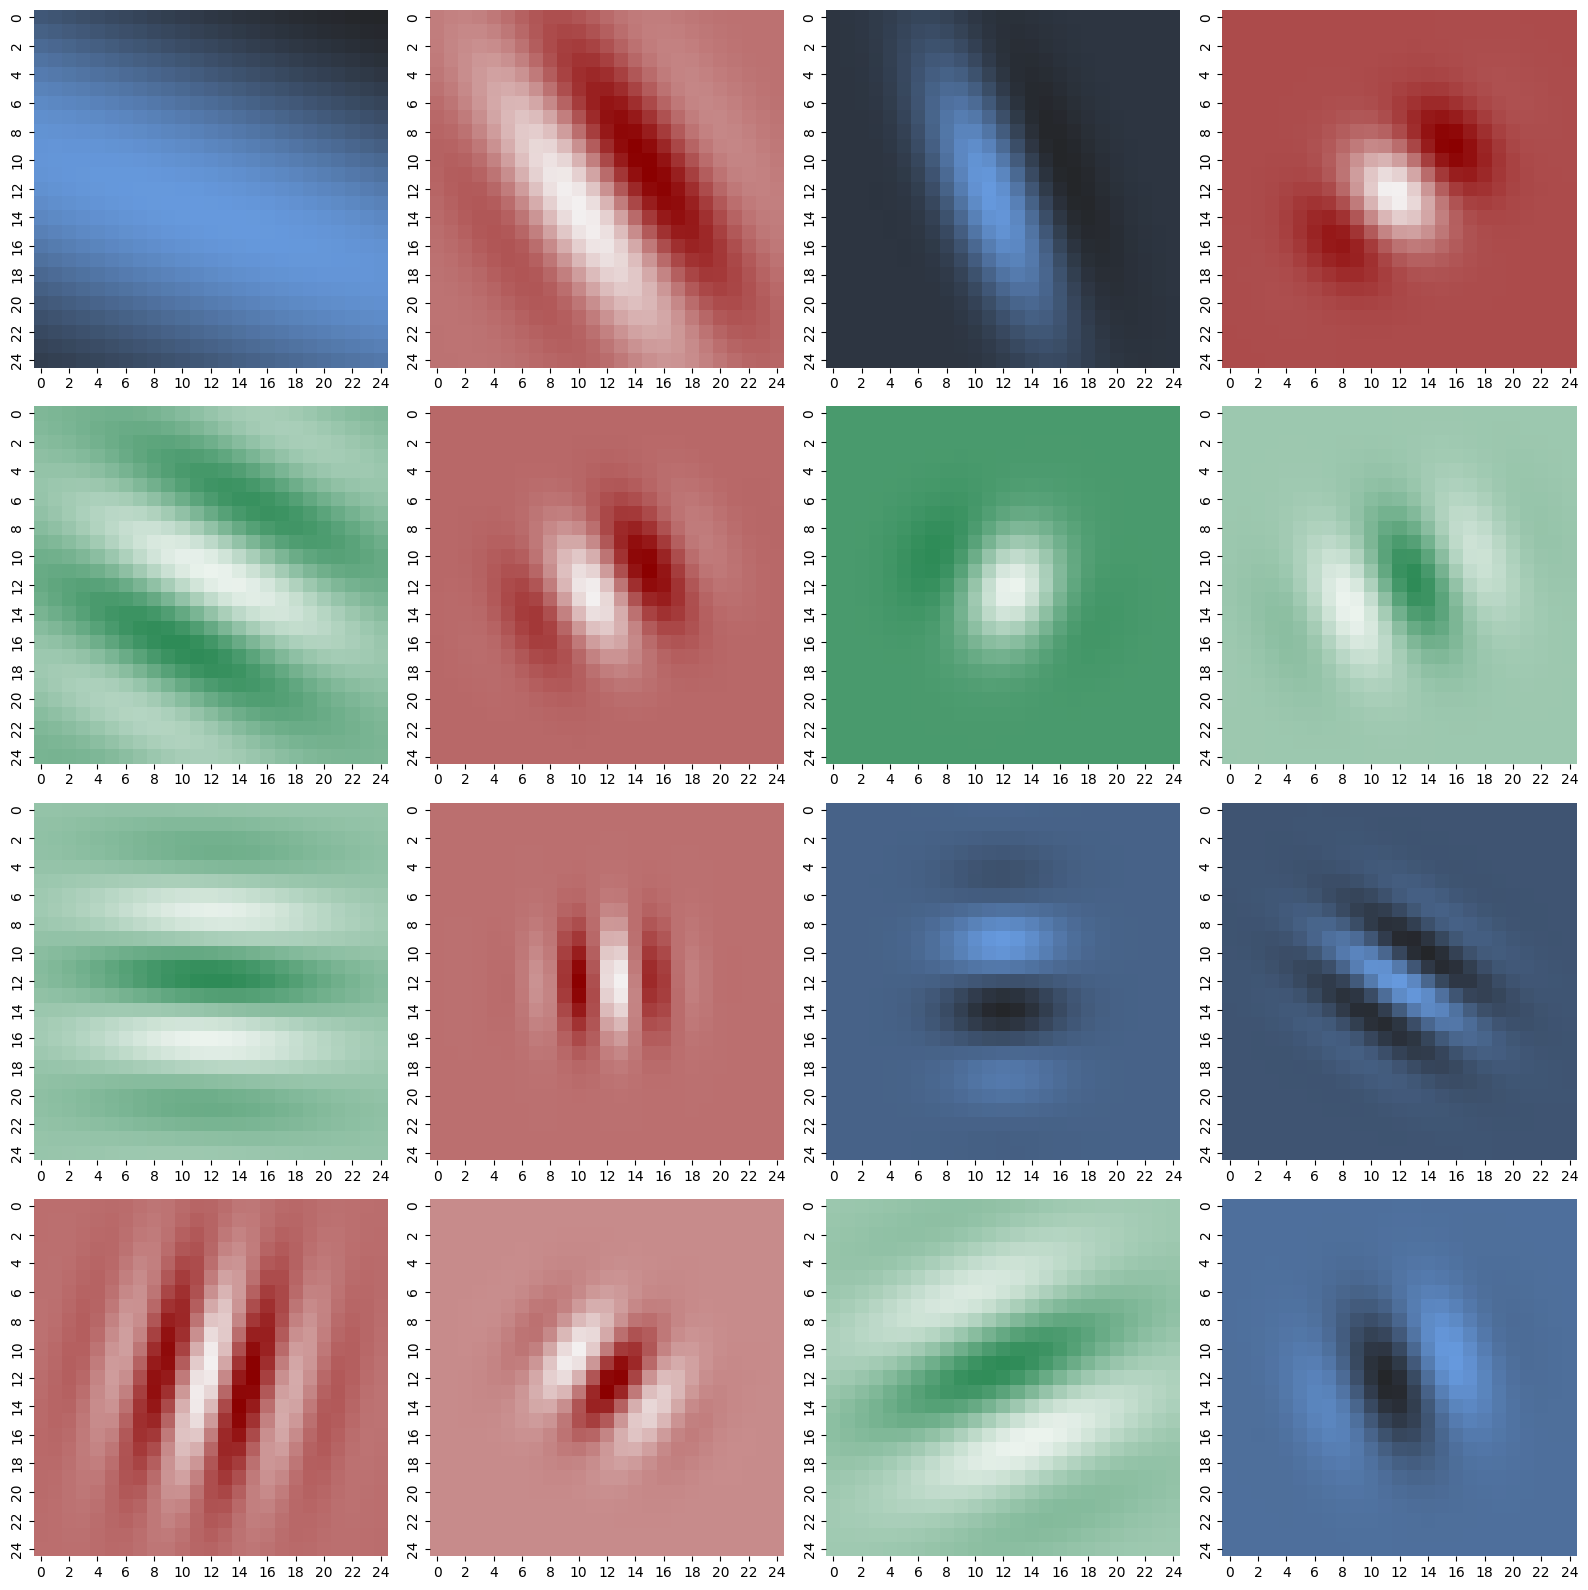

In [237]:
# Create a figure and axis object using Matplotlib
rows = int(np.sqrt(simple_channels+complex_channels))
fig, axes = plt.subplots(rows, rows, figsize = (16,16))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < len(filters_r):
        cnl = random_channel[i]
        sns.heatmap(filters_r[i][cnl], ax=ax, cmap=cmaps[chnls[cnl]], cbar=False)
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [238]:
def data():
    dataset = torchvision.datasets.ImageFolder(
        os.path.join("tiny-imagenet-200", 'train'),
        torchvision.transforms.Compose([
            # torchvision.transforms.RandomResizedCrop(224),
            torchvision.transforms.RandomAffine(degrees=30, translate=(0.05, 0.05), scale=(1, 1.2)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
        ]))
    data_loader = torch.utils.data.DataLoader(dataset,
                                                batch_size=128,
                                                shuffle=True,
                                                num_workers=2,
                                                pin_memory=True)

    return data_loader

In [239]:
train_data = data()

In [11]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():
    device = "mps"
    mps = True
else:
    device = "cpu"

In [241]:
device

'mps'

In [242]:
von = VOneNet(gabor_seed=0, simple_channels=simple_channels, complex_channels=complex_channels, model_arch="resnet18", noise_mode="None", k_exc=k_exc, ksize=ksize, stride = stride, image_size=image_size, visual_degrees=visual_degrees, sf_min = sf_min, sf_max = sf_max).to(device)
voneblock = von[0]


ksz = (ksize,ksize)

voneblock.simple_conv_q0.weight = nn.Parameter(F.interpolate(voneblock.simple_conv_q0.weight, size = ksz), requires_grad = False)
voneblock.simple_conv_q1.weight = nn.Parameter(F.interpolate(voneblock.simple_conv_q1.weight, size = ksz), requires_grad = False)

voneblock.ksize = ksize

voneblock.simple_conv_q0.padding = (voneblock.ksize//2, voneblock.ksize//2)
voneblock.simple_conv_q1.padding = (voneblock.ksize//2, voneblock.ksize//2)

filters_r = voneblock.simple_conv_q0
filters_c = voneblock.simple_conv_q1

Neuronal distributions gabor parameters
Model:  VOneResNet18
Number of classes:  200


/Users/metehergul/vonenet-mete/vonenet/params.py:59: RuntimeWarning: invalid value encountered in divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


In [244]:
output_path = f"{simple_channels}x{complex_channels}x{batch_size}x{25}xlow_sf"
output_path

'8x8x128x25xlow_sf'

In [245]:
voneblock = voneblock.to(device)

cov_dim = (simple_channels+complex_channels)*32**2
print(cov_dim)
count = len(train_data)
cov_matrix = torch.zeros(cov_dim, cov_dim).to(device)

for step, data in enumerate(tqdm.tqdm(train_data)):
    
    with torch.no_grad():
        
        outputs = voneblock.forward(data[0].to(device))

        p1 = outputs.reshape(-1, cov_dim)

        term1 = p1.T @ p1 / data[1].shape[0]

        m1 = torch.mean(p1, dim=0)
        m1.shape
        mn = torch.outer(m1, m1)

        cov_matrix += term1 - mn

        if device == "cuda":
            torch.cuda.empty_cache()


cov_matrix /= count

try:
    os.mkdir(output_path)
except:
    print("Directory already exists.")
    pass

torch.save(cov_matrix, output_path+"/cov_matrix.pt")

16384


100%|██████████| 782/782 [01:40<00:00,  7.79it/s]


In [199]:
for step, dt in enumerate(train_data):

    if step == 0:
        first_sample = dt
    
    last_sample = dt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

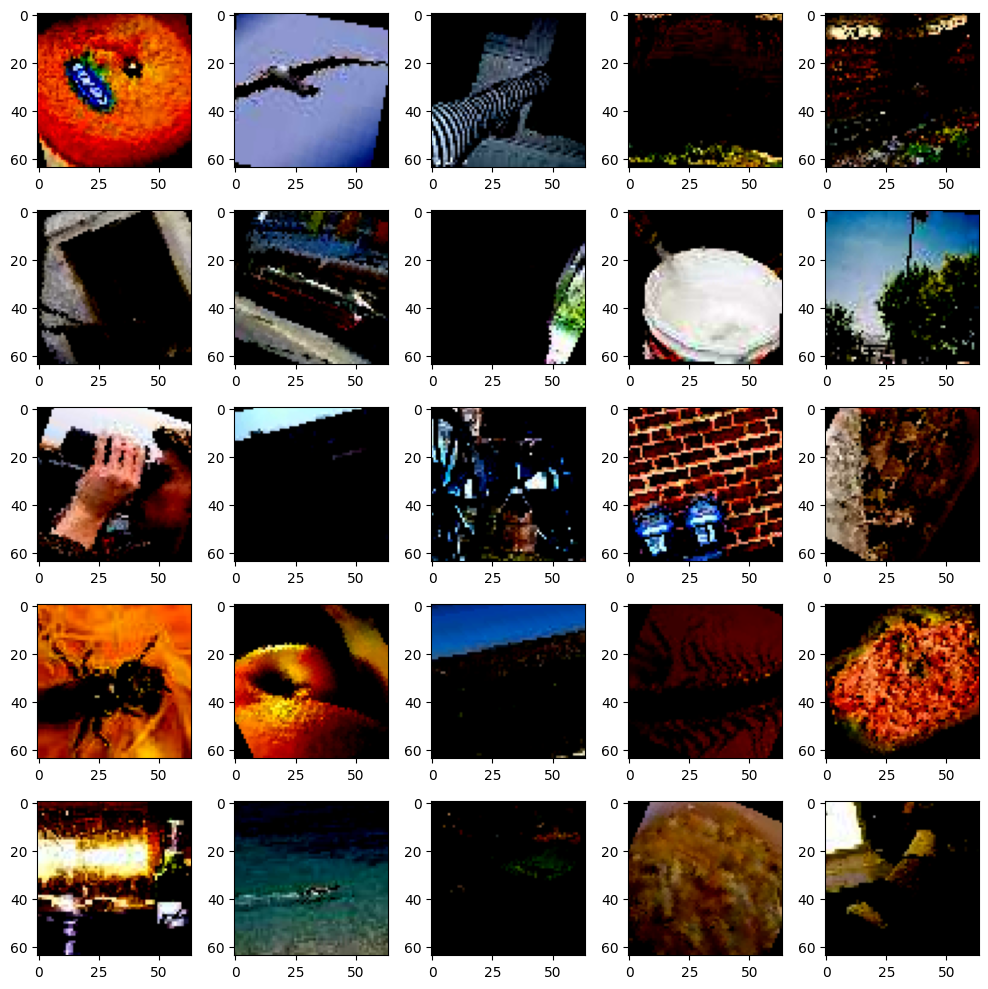

In [200]:
# Create a figure and axis object using Matplotlib
cnt = 25
rows = int(np.sqrt(cnt))

fig, axes = plt.subplots(rows, rows, figsize = (2*rows,2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):

    img = first_sample[0][i].permute(1,2,0)
    ax.imshow(img)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

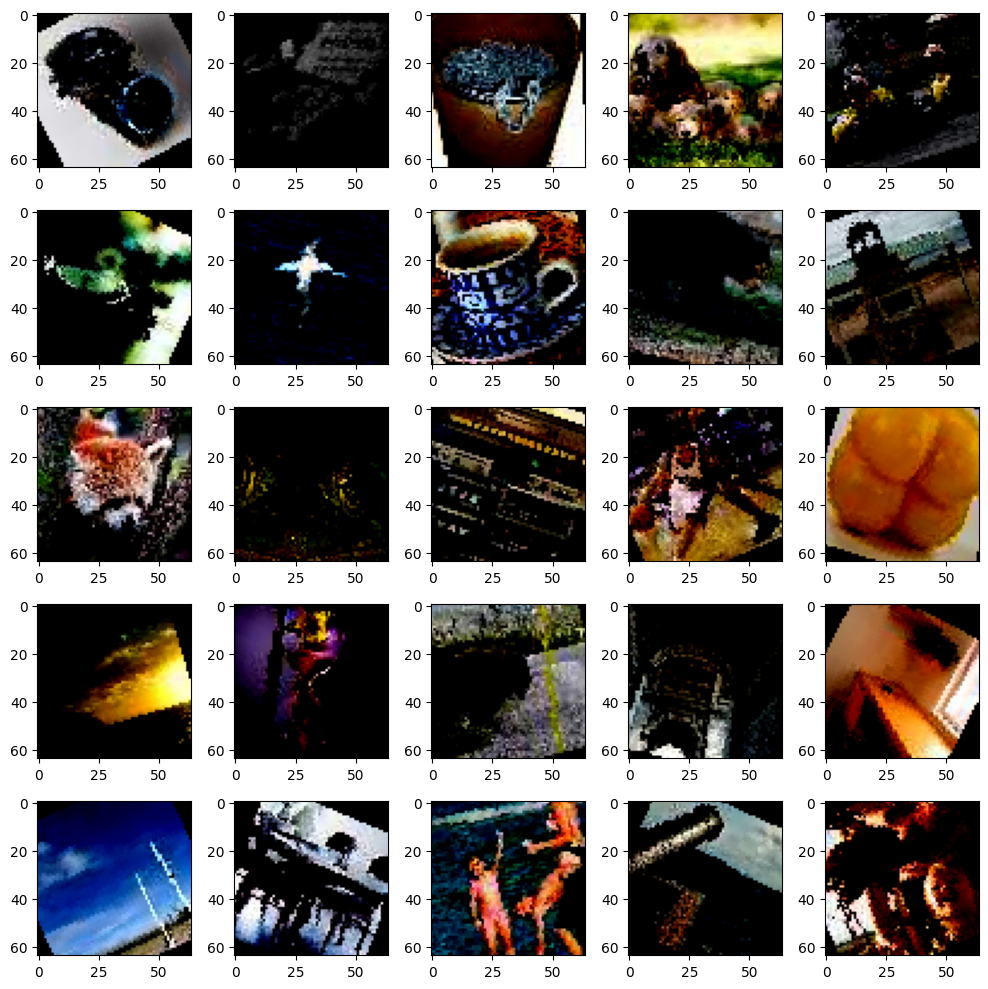

In [201]:
# Create a figure and axis object using Matplotlib
cnt = 25
rows = int(np.sqrt(cnt))

fig, axes = plt.subplots(rows, rows, figsize = (2*rows,2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):

    img = last_sample[0][i].permute(1,2,0)
    ax.imshow(img)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [246]:
cov_matrix.shape

torch.Size([16384, 16384])

In [247]:
filters_r = voneblock.simple_conv_q0
filters_c = voneblock.simple_conv_q1

torch.save(filters_r, output_path+"/real_filters.pt")
torch.save(filters_c, output_path+"/imaginary_filters.pt")

In [8]:
output_path = f"{simple_channels}x{complex_channels}x{batch_size}x25xhigh_sf"

In [9]:
cov_matrix = torch.load(output_path+"/cov_matrix.pt")
filters_r = torch.load(output_path+"/real_filters.pt")
filters_c = torch.load(output_path+"/imaginary_filters.pt")

In [12]:
from vonenet.vonenet import VOneNetDN

vondn = VOneNetDN(simple_channels=simple_channels, gabor_seed=0, complex_channels=complex_channels, model_arch="resnet18", noise_mode = None, k_exc=25, ksize=25, stride = stride, image_size=image_size, visual_degrees=visual_degrees,
                  filters_r = filters_r, filters_c = filters_c, cov_matrix = cov_matrix).to(device)

Neuronal distributions gabor parameters
Cov matrix passed to DNBlock
Model:  VOneResNet18
Number of classes:  200


In [13]:
voneblock = vondn[0]
voneblock

VOneBlockDN(
  (simple_conv_q0): GFB()
  (simple_conv_q1): GFB()
  (simple): ReLU(inplace=True)
  (complex): Identity()
  (gabors): Identity()
  (noise): ReLU(inplace=True)
  (output): Identity()
  (dn): DNBlock()
)

In [14]:
outputs_inter = voneblock.gabors_f(first_sample[0].to(device))
outputs_inter.shape

NameError: name 'first_sample' is not defined

In [15]:
tensor_a = outputs_inter  # Tensor of shape (128, 64, 32, 32)
matrix_b = torch.rand(16, 16).to(device)           # Tensor of shape (64, 64)

# Reshape tensor_a to (128, 32, 32, 64) to prepare for matrix multiplication
inter = tensor_a.permute(0, 2, 3, 1)
result = torch.einsum('bxyc,cd->bxyc', inter, matrix_b)
tensor_a_reshaped = result.permute(0, 3, 1, 2)

sz = tensor_a_reshaped.shape[1]
btc = 0 # index of img in batch

rows = int(np.sqrt(sz))
fil = tensor_a_reshaped[btc][:sz,::]

# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(rows, rows, figsize=(2*rows, 2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < rows * rows:
        ax.imshow(fil[i].to("cpu"))
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'outputs_inter' is not defined

torch.Size([16, 32, 32])


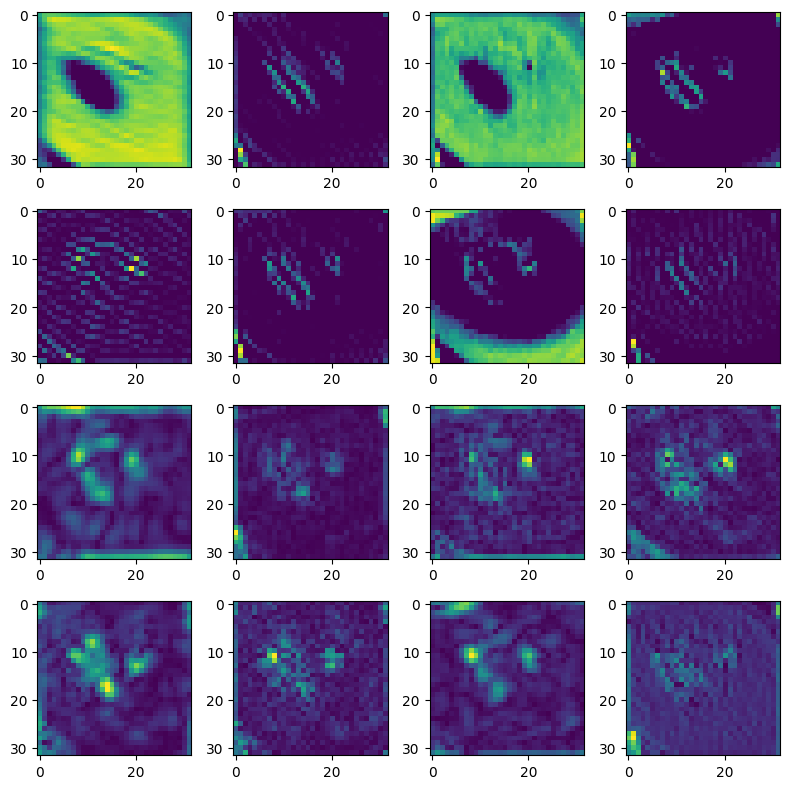

In [305]:
sz = outputs_inter.shape[1]
btc = 0 # index of img in batch

rows = int(np.sqrt(sz))
fil = outputs_inter[btc][:sz,::]
print(fil.shape)
# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(rows, rows, figsize=(2*rows, 2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < rows * rows:
        ax.imshow(fil[i].to("cpu"))
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

torch.Size([16, 32, 32])


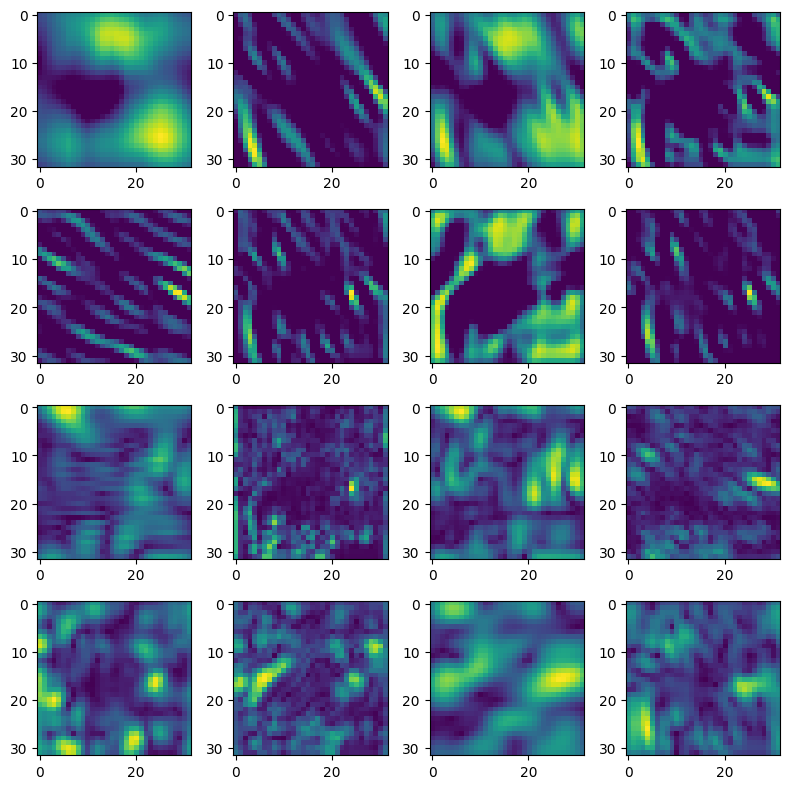

In [167]:
sz = outputs_inter.shape[1]
btc = 0 # index of img in batch

rows = int(np.sqrt(sz))
fil = outputs_inter[btc][:sz,::]
print(fil.shape)
# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(rows, rows, figsize=(2*rows, 2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < rows * rows:
        ax.imshow(fil[i].to("cpu"))
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [63]:
16*32*32

16384

In [84]:
cov_matrix.shape

torch.Size([16384, 16384])

In [32]:
cov_matrix.shape[0]

16384

In [66]:
rho = 64 // 2 // 2
inds = np.int64(np.random.multivariate_normal([16,16], [[rho,0],[0,rho]], 10))

In [67]:
u = np.arange(0,1024).reshape(32,32)
positions = [u[pos[0]][pos[1]] for pos in inds]
positions

[402, 432, 434, 591, 555, 337, 530, 819, 404, 334]

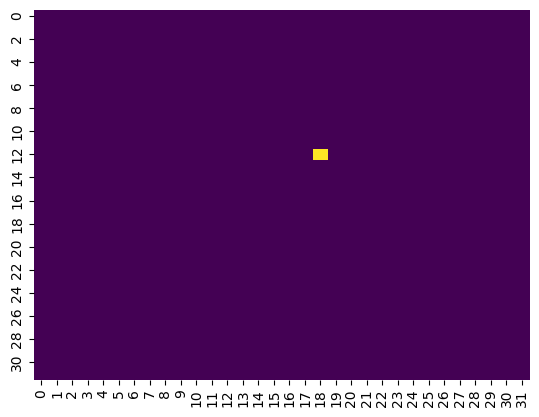

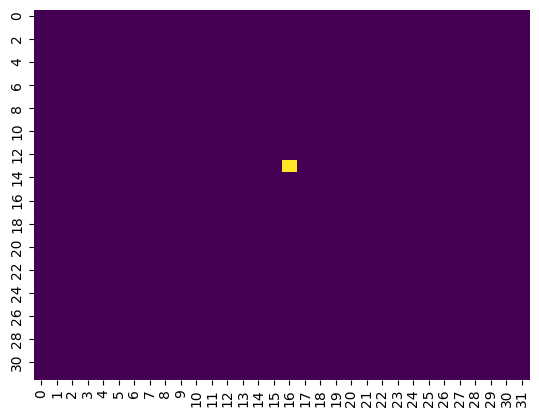

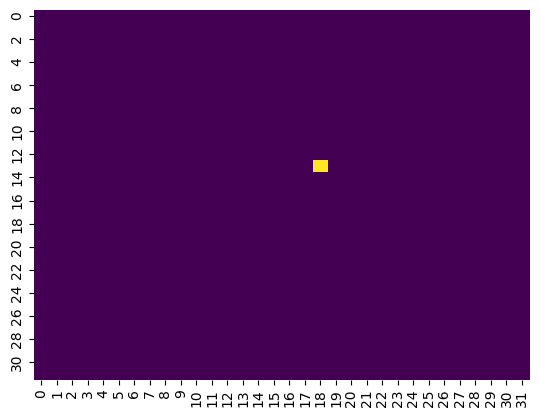

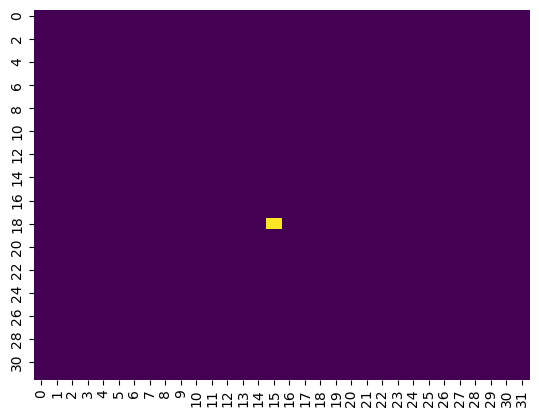

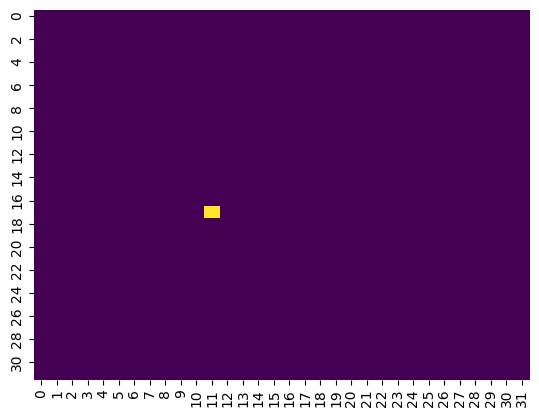

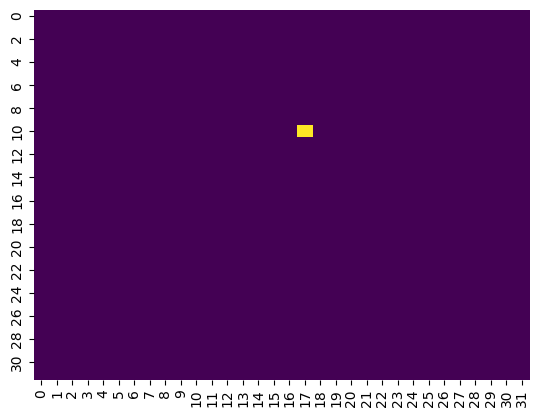

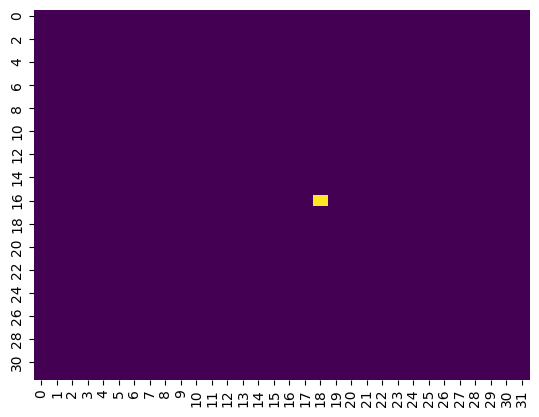

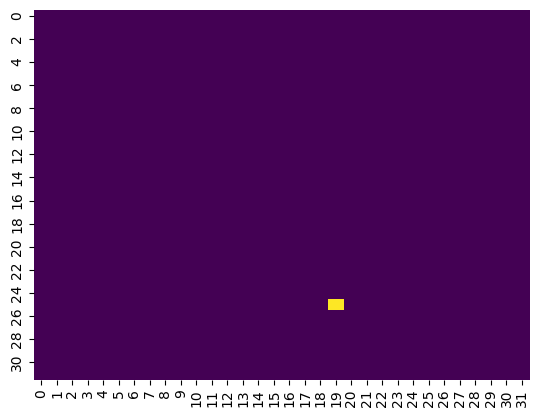

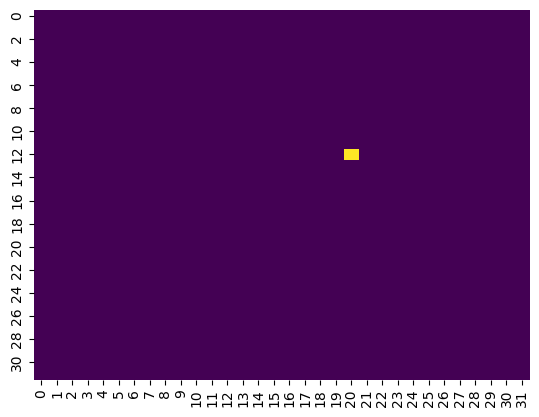

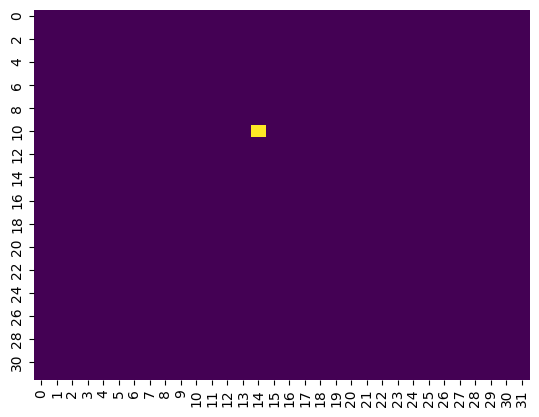

In [68]:
for ind in positions:
    gr = np.zeros(32**2)
    gr[ind] = 1
    sns.heatmap(gr.reshape(32,32), cmap="viridis", cbar=False)
    plt.show()

torch.Size([16, 32, 32])


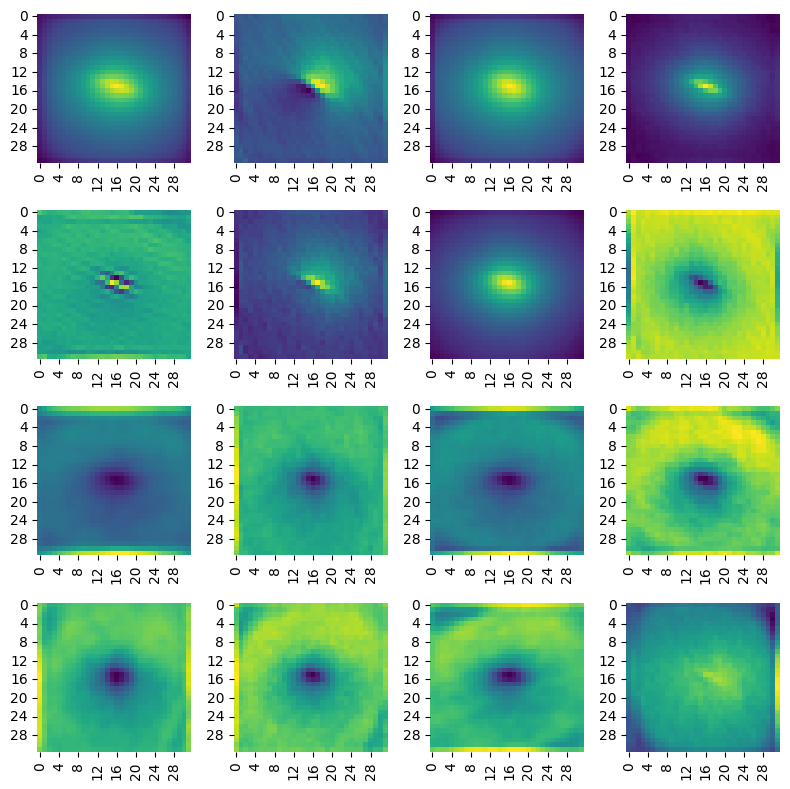

In [52]:
covvies = cov_matrix[ind].reshape(16, image_size//stride, image_size//stride)
covvies.shape

sz = covvies.shape[0]

rows = int(np.sqrt(sz))
fil = covvies
print(fil.shape)
# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(rows, rows, figsize=(2*rows, 2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < rows * rows:
        sns.heatmap(fil[i].to("cpu"), ax=ax, cmap="viridis", cbar=False)
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [315]:
first_sample[0].shape

torch.Size([128, 3, 64, 64])

In [69]:
outputs_inter = first_sample[0].permute(0,3,2,1)

NameError: name 'first_sample' is not defined

In [345]:
trial = outputs_inter.reshape(-1, np.prod(list(outputs_inter.shape[1:])))

covved = cov_matrix @ trial.T

covved = covved.T.reshape(128, 16, 1024)

covved = (covved / covved.max(2, keepdim=True)[0]).reshape(outputs_inter.shape)

In [346]:
covved.shape

torch.Size([128, 16, 32, 32])

torch.Size([16, 32, 32])


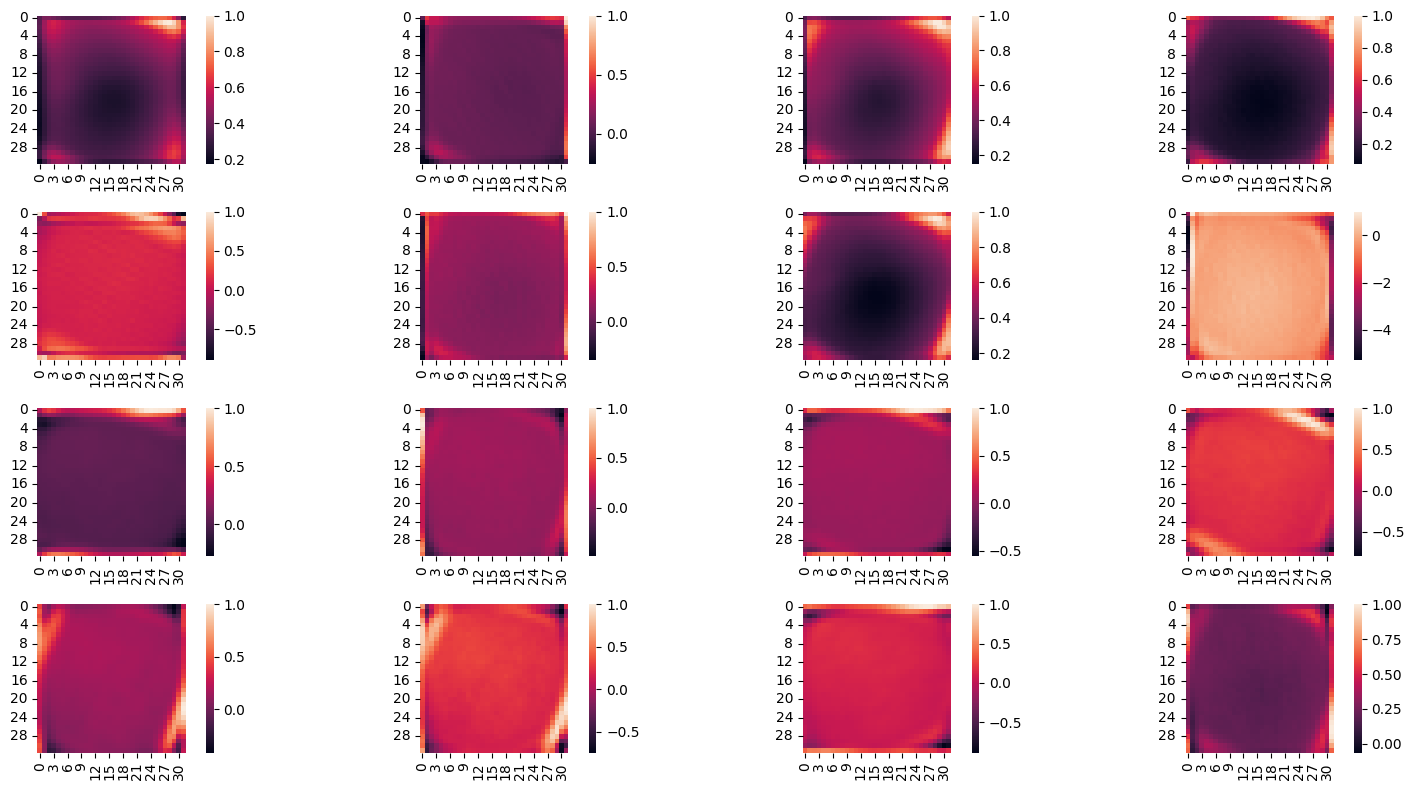

In [347]:
sz = covved.shape[1]
btc = 1 # index of img in batch

rows = int(np.sqrt(sz))
fil = covved[btc][:sz,::]
print(fil.shape)
# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(rows, rows, figsize=(4*rows, 2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < rows * rows:
        sns.heatmap(fil[i].to("cpu"), ax = ax, square = True)
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [266]:
outputss = voneblock.forward(first_sample[0].to(device))

In [276]:
outputss.shape

torch.Size([128, 16, 32, 32])

In [295]:
tensor_a = torch.rand(128, 64, 32, 32)  # Tensor of shape (128, 64, 32, 32)
matrix_b = torch.rand(64, 64)           # Tensor of shape (64, 64)

# Reshape tensor_a to (128, 32, 32, 64) to prepare for matrix multiplication
tensor_a_reshaped = tensor_a.permute(0, 2, 3, 1)
tensor_a_reshaped.shape

torch.Size([128, 32, 32, 64])

In [ ]:


# Perform matrix multiplication using torch.einsum
result = torch.einsum('bxyc,cd->bxyc', tensor_a_reshaped, matrix_b)

# Permute back to the original shape
result = result.permute(0, 3, 1, 2)

print(result.shape)  # Should print torch.Size([128, 64, 32, 32])

In [284]:
coeffs = torch.rand(16,16)
print(coeffs.shape)

out2 = outputs.reshape(128,16,-1)
print(out2.shape)

outputs.reshape(128,16,-1)*coeffs[0].unsqueeze(0)

torch.Size([16, 16])
torch.Size([128, 16, 256])


RuntimeError: The size of tensor a (256) must match the size of tensor b (16) at non-singleton dimension 2

In [267]:
outputss.shape

torch.Size([128, 16, 32, 32])

torch.Size([16, 32, 32])


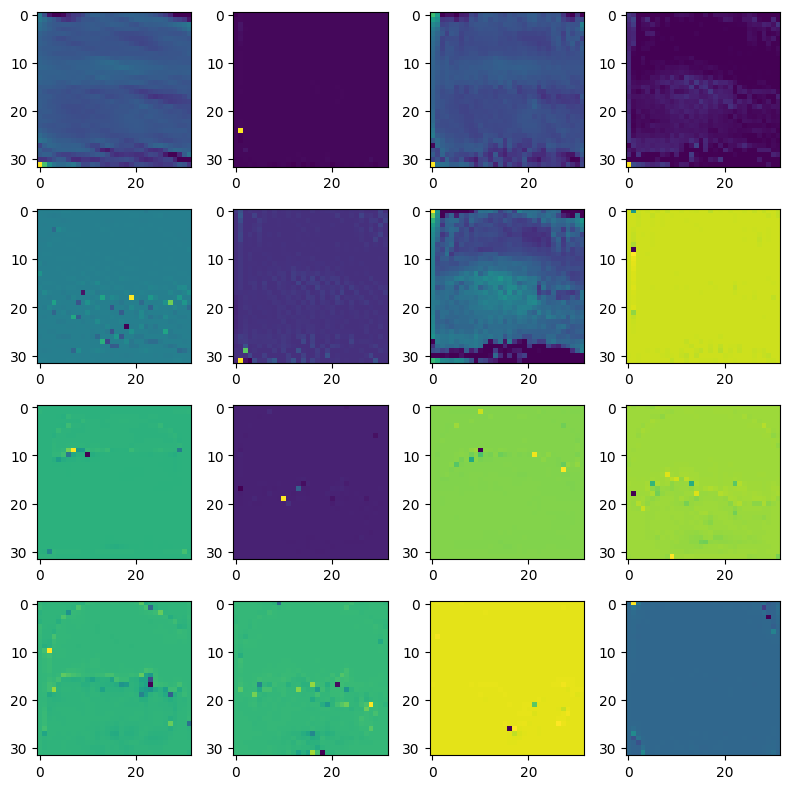

In [271]:
sz = outputss.shape[1]
btc = 3 # index of img in batch

rows = int(np.sqrt(sz))
fil = outputss[btc][:sz,::]
print(fil.shape)
# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(rows, rows, figsize=(2*rows, 2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < rows * rows:
        ax.imshow(fil[i].to("cpu"))
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

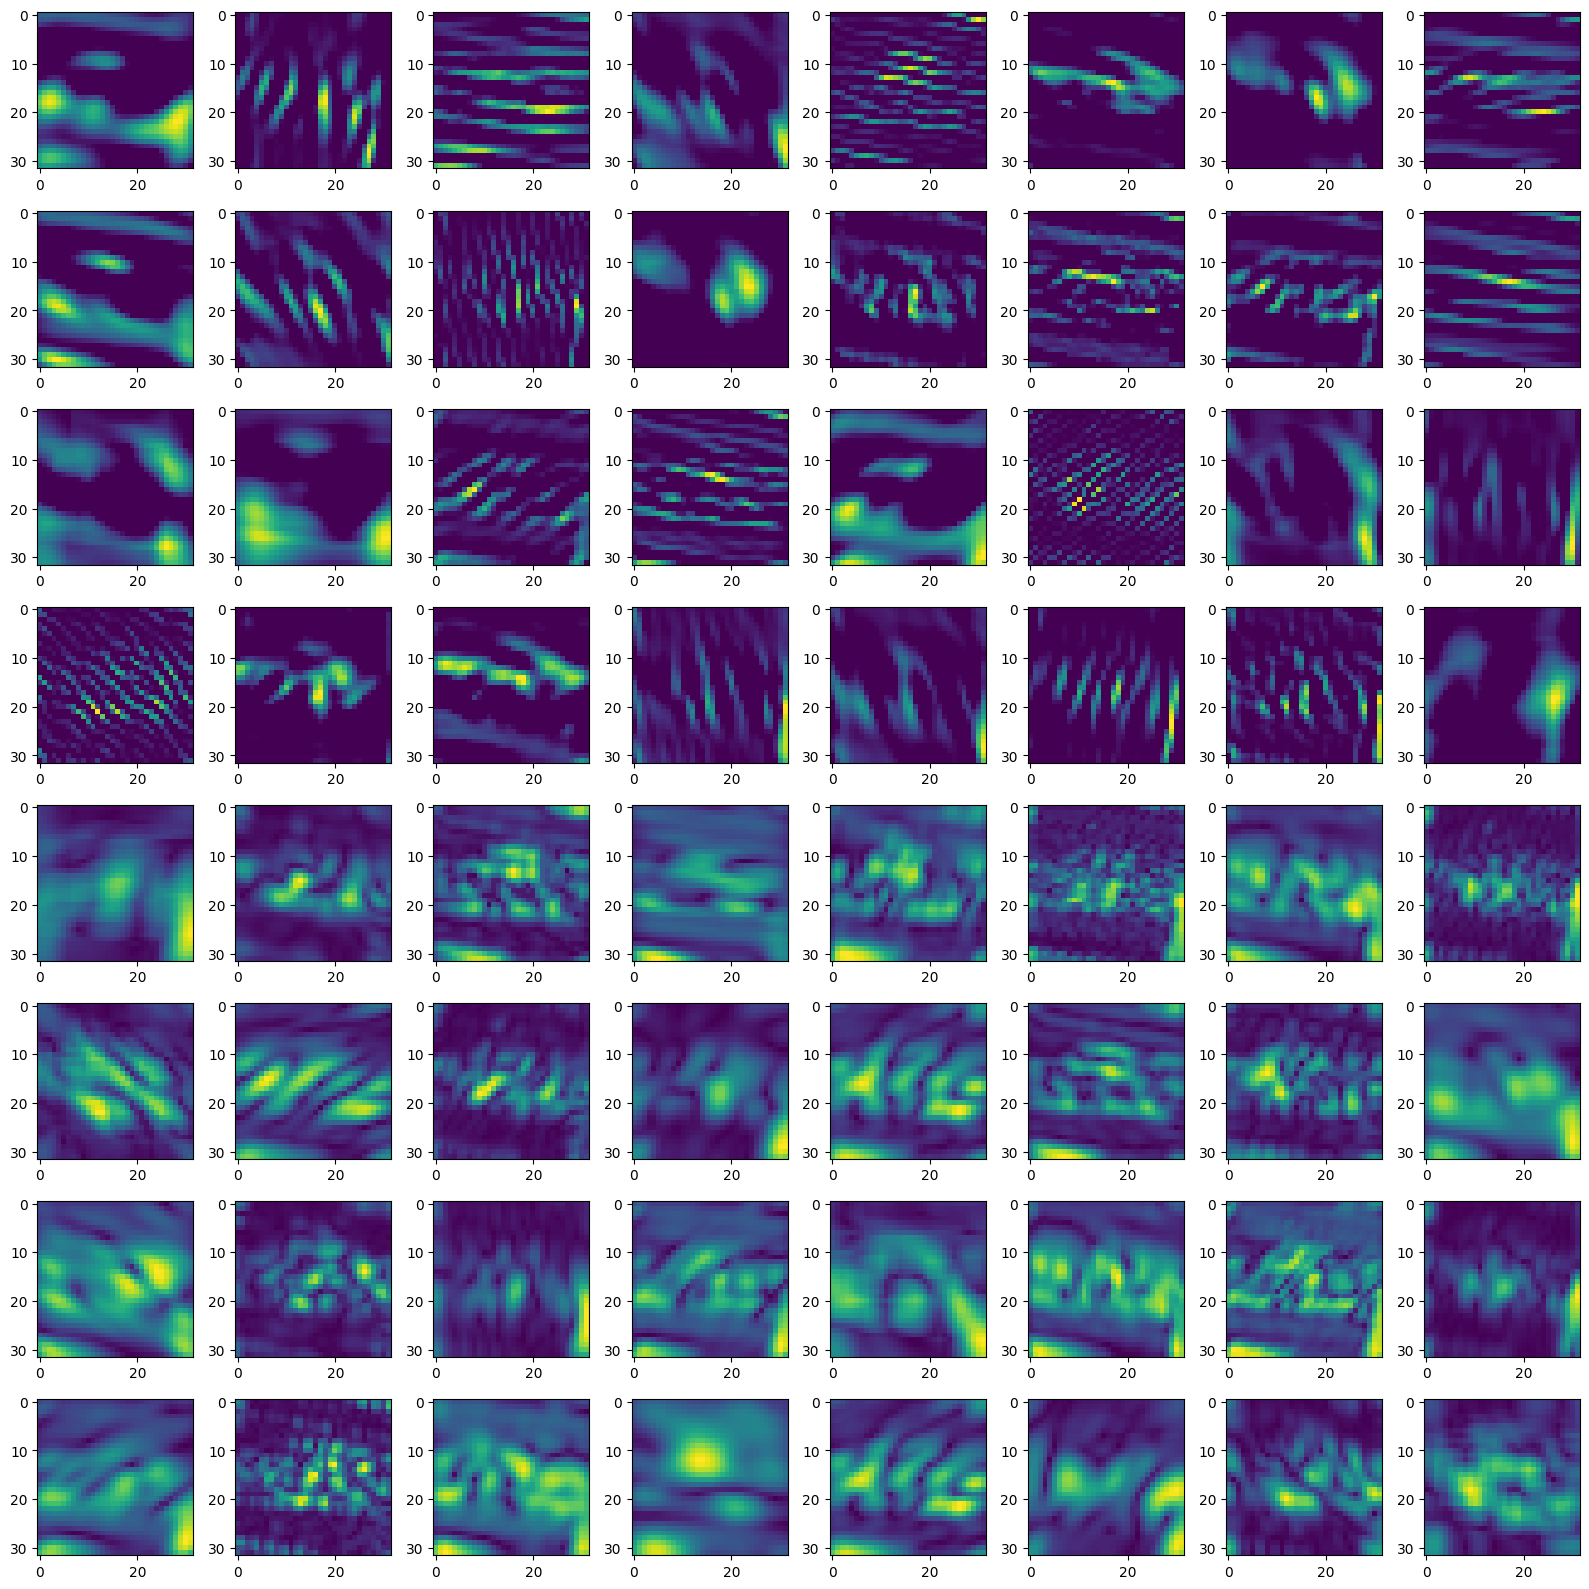

In [97]:
outputss = voneblock.forward(last_sample[0])

sz = outputss.shape[1]
btc = 4 # index of img in batch

rows = int(np.sqrt(sz))
fil = outputss[btc][:sz]
# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(rows, rows, figsize=(2*rows, 2*rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < rows * rows:
        ax.imshow(fil[i].to("cpu"))
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [162]:
outputss.shape

torch.Size([32, 16, 32, 32])

In [187]:
np.prod(list(outputs.shape[1:]))

16384

In [170]:
inp = outputs.reshape(-1, (simple_channels+complex_channels)*pixels).to("mps")

den = (cov_matrix@inp.T).T.to("cpu")

In [189]:
den.shape

torch.Size([128, 16384])

In [192]:
denn = den.reshape(outputs.shape)
denn.shape

torch.Size([128, 16, 32, 32])

In [ ]:
outputs

In [194]:
bias = 1e-6
res = outputs / (bias + denn)

In [174]:
ress = res.reshape(-1, simple_channels+complex_channels, *resolution)
ress.shape

torch.Size([128, 16, 32, 32])

In [203]:
divvie = res[18]

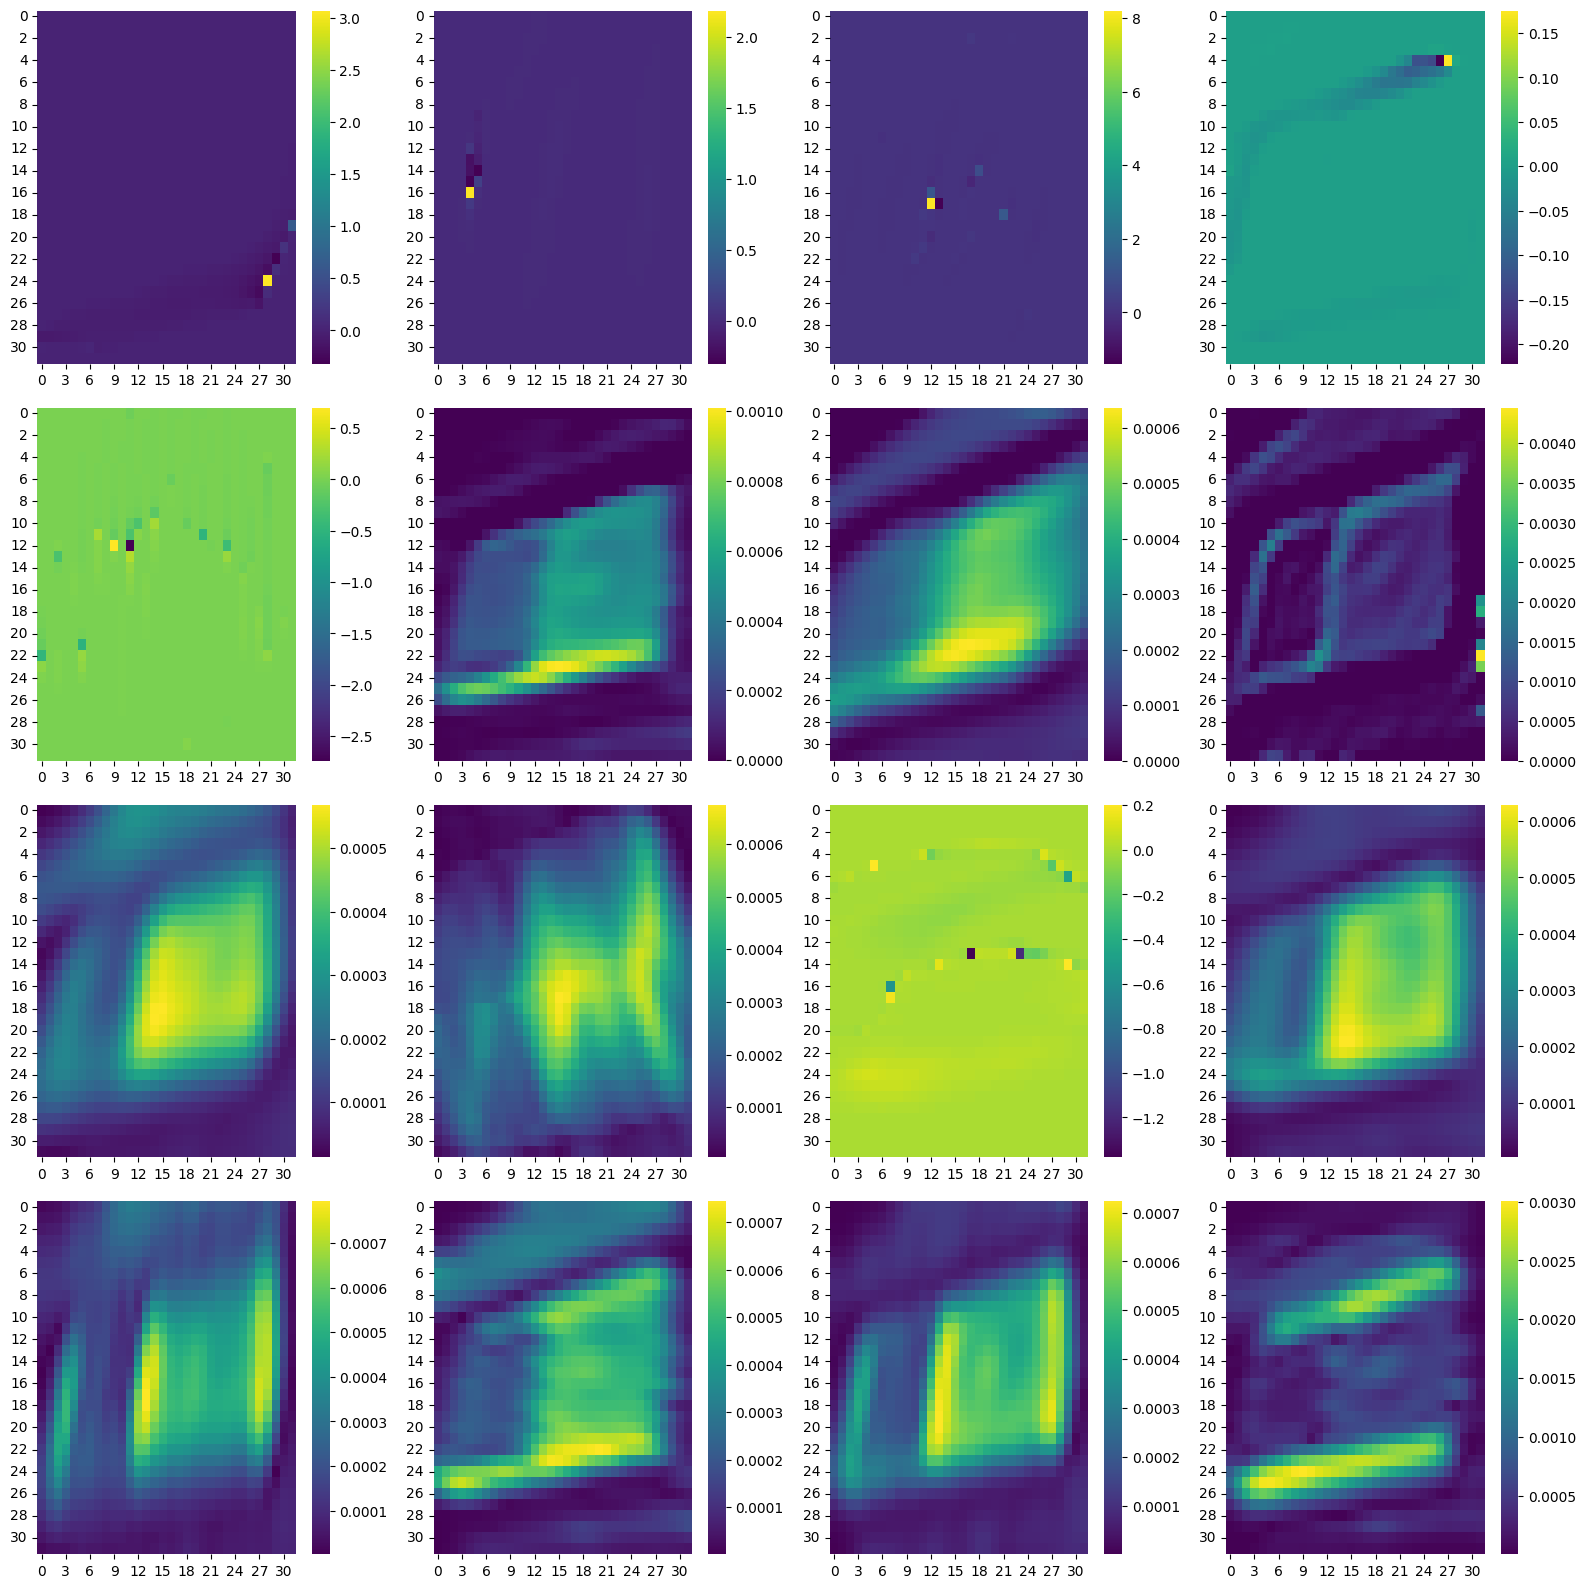

In [204]:
# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < len(divvie):
        sns.heatmap(divvie[i], ax=ax, cmap="viridis", cbar=True)
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# 16384, 16384
# multiplying through gives 16384
# this contains 16 x 16 x 1024 normalising overlays
# sum for each channel to get denominator term
# divide channel response to get eventual

In [206]:
cov_matrix = torch.load("8x8x128/cov_matrix.pt")
cov_matrix.shape

torch.Size([16384, 16384])

In [171]:
out.shape, divvie.shape

(torch.Size([128, 16, 32, 32]), torch.Size([16, 32, 32]))

In [196]:
divvie.shape

torch.Size([16, 32, 32])

In [175]:
bias = 1e-6
divvies = out / (bias + divvie.unsqueeze(0))

In [176]:
divvies.shape

torch.Size([128, 16, 32, 32])

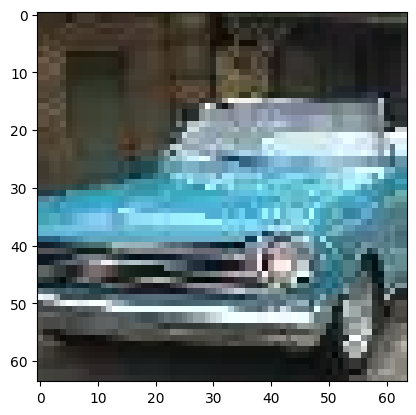

In [194]:
img = last_sample[0][24].permute(1,2,0)
plt.imshow(img)

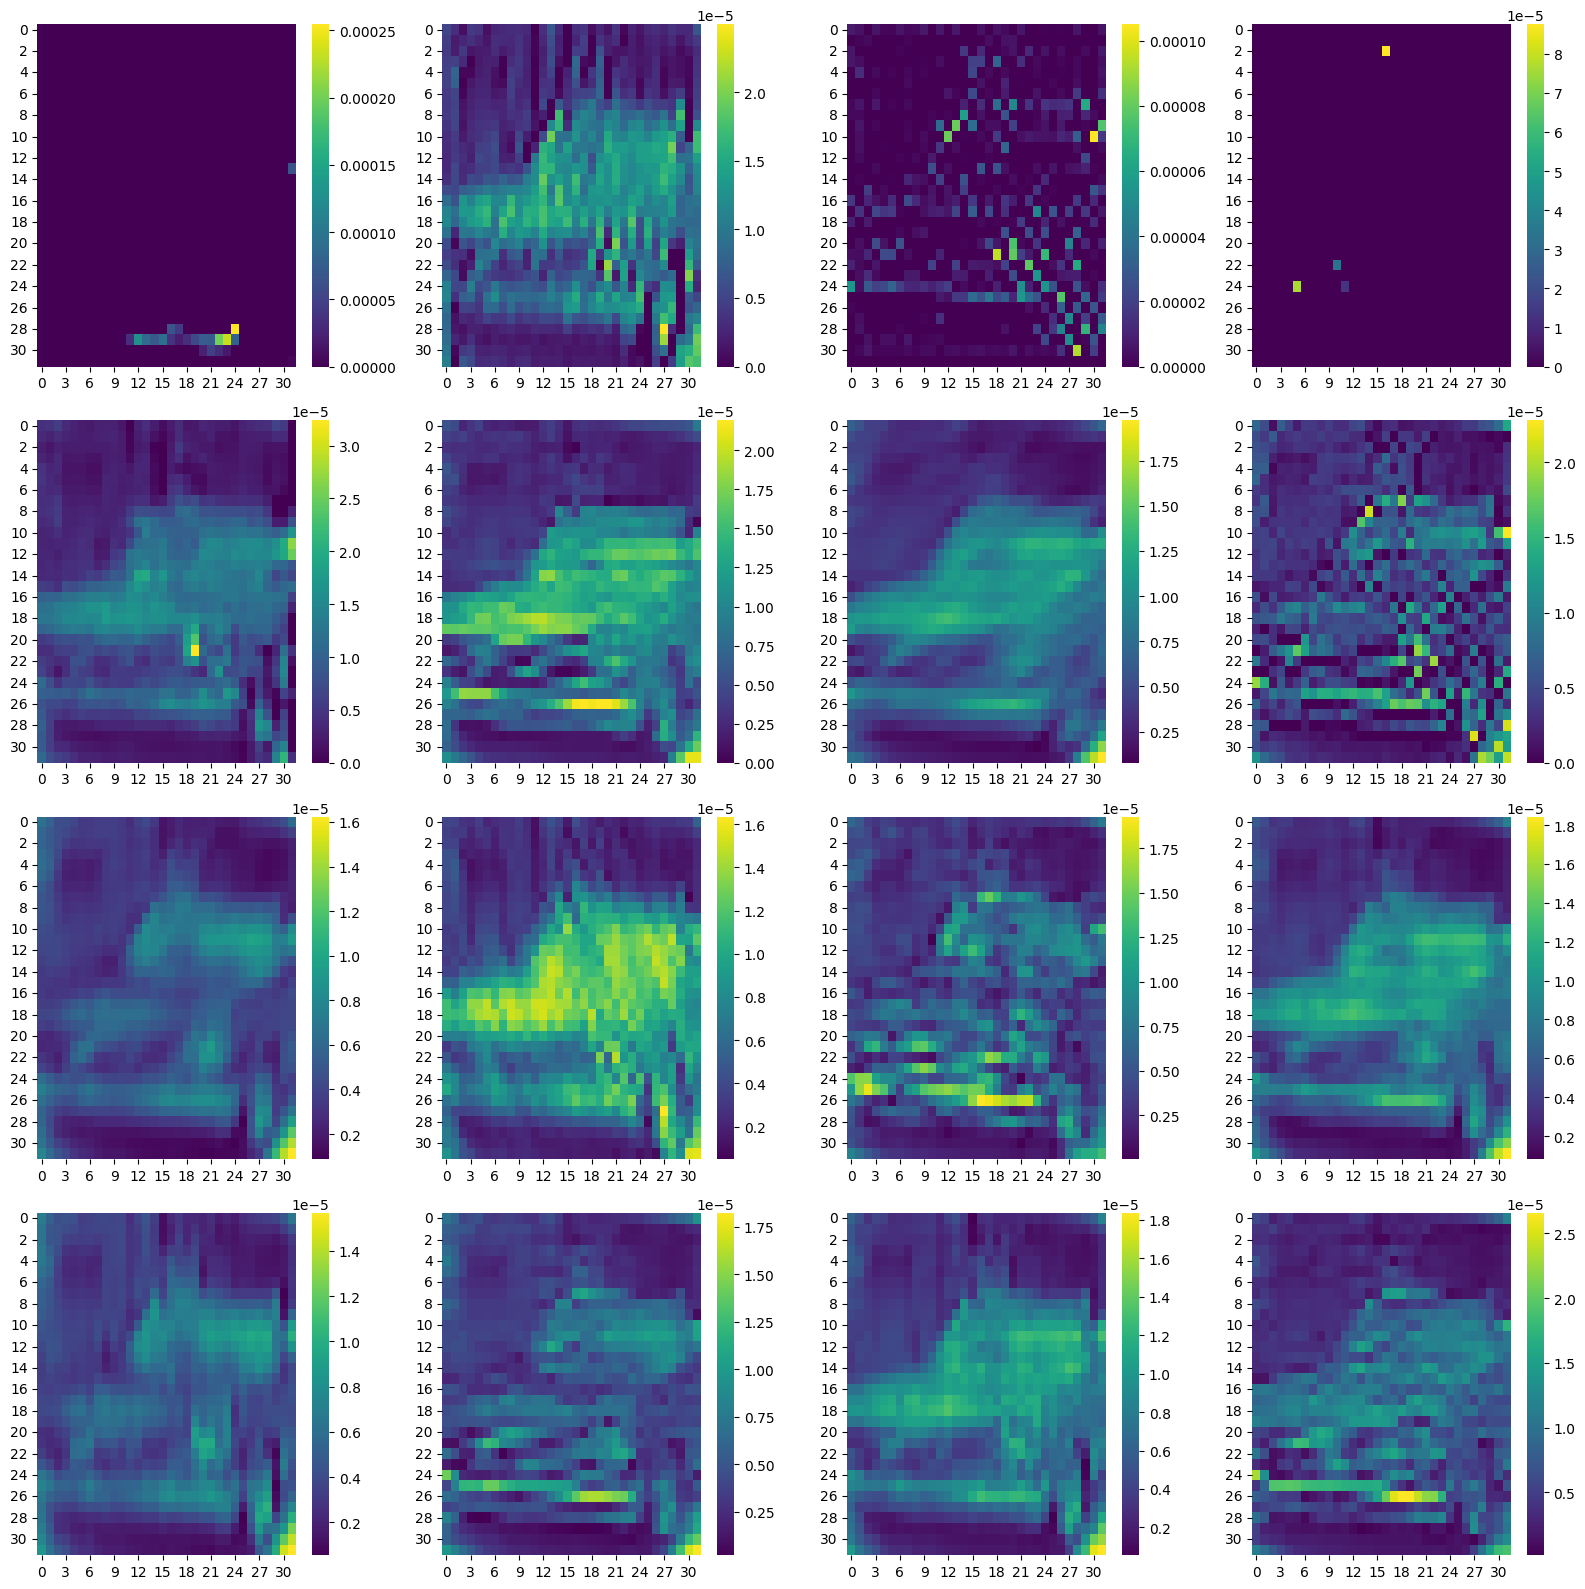

In [195]:
bias = 1e-6
divviee = divvies[24]

# Create a figure and axis object using Matplotlib
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each subplot and plot the heatmap
for i, ax in enumerate(axes):
    if i < len(divviee):
        sns.heatmap(divviee[i], ax=ax, cmap="viridis", cbar=True)
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
# propagating through gfb each time may not be the most sensible thing to do here.
# parameters fixed, resulting output given dataset fixed. compute and store might be a reasonable option.

In [6]:
# here, we have a 128x512x(W/d)x(H/d) output for a batch of 128 images. WxH are image dimensions, d is GFB stride.
# each channel response will be correlated with each other on a 1-1 basis
# ideally, linearisation happens from the 2nd dimension onwards, but this is largely RAM-constrained
# for reference, replicating the 128-batch, 512-channel VON method on 64x64 images using a 4-stride would require:
batch_size = 128
channels = 512
stride = 2
img_dim = 64/stride

(channels * img_dim ** 2) ** 2 * 32 / 8 / 2**30 # in gb

# per covariance matrix. a more  compact implementation is therefore required.

1024.0

In [8]:
(512 * 7**2) ** 2 *32 / 8 / 2**30

2.3447265625

In [20]:
batch_size = 128
channels = 64
stride = 2
img_dim = 64/stride

((channels * (img_dim ** 2)) ** 2) * 4 / 2**30 # in gb

16.0

In [24]:
(channels*(img_dim**2))**2 *32 / 8 / 2**30

16.0

In [5]:
2 ** 16

65536

In [6]:
device = torch.device("mps:0")
device

device(type='mps', index=0)

In [7]:
# an alternative method is therefore required in order to compute cov matrices on a per-batch basis.

In [8]:
# dimensionality of batches.
batch_size = 128
channels = 128
img_dim = 16

batch = torch.randn(batch_size, channels, img_dim, img_dim)
batch = batch.reshape(batch_size, -1)
batch = batch.T
batch.shape

torch.Size([32768, 128])

In [10]:
def outer1(a,b):
    return torch.einsum('i,j->ij', a, b)

def outer2(a,b):
    return torch.einsum('bi,bj->bij', a, b)

In [17]:
import tqdm

In [18]:
@torch.jit.script
def outer_numba(a, b):
    m = a.shape[0]
    n = b.shape[0]
    result = torch.empty((m, n), dtype=torch.float)
    for i in range(m):
        for j in range(n):
            result[i, j] = a[i]*b[j]
    return result

In [20]:
# this is also an extremely costly operation on the gpu, time-wise.

In [12]:
def ops(batch=batch, batch_size=batch_size):
    mean = torch.mean(batch, dim=1)
    res2 = batch@batch.T / batch_size
    cov = res2 - outer1(mean, mean)
    den = cov@batch
    return den

In [14]:
ops()

tensor([[-421.6979, -291.4351,  -57.7972,  ...,  -60.4283,  174.5699,
          200.8408],
        [ 328.8390,  230.8167,   69.3959,  ...,  214.1236, -318.6667,
          161.8678],
        [  49.1287,   72.7420, -172.3016,  ...,  411.9048,  265.3748,
         -279.4073],
        ...,
        [ 373.3488,  327.1681,  -73.6682,  ..., -334.9337,  296.7198,
          517.7131],
        [ 274.6473,  259.2677,  -21.8054,  ...,  274.3643,   47.1189,
          -19.5655],
        [-163.4248,  -85.5708, -559.8054,  ..., -356.6627,  189.2984,
          335.9614]])

In [17]:
T = 12.7
100000/128 * T / 3600 # hrs

2.756076388888889

In [ ]:
# compute per each epoch (not sensible)
# once at beginning, then store (100000/128*4.3gb in ram...)

In [24]:
cov[0].shape

torch.Size([32768])

In [5]:
# ideally, the cov matrix here constitutes the starting point for the weights.

In [26]:
den.shape

torch.Size([32768, 128])

In [27]:
bias = 0.1
den += bias

In [6]:
result = torch.div(batch.T, den.T)
channels = 128
result.reshape((batch_size, channels, img_dim, img_dim)).shape

NameError: name 'batch' is not defined

NameError: name 'result' is not defined

In [30]:
# this is how the procedure would normally be implemented from the get-go. next up is generalised divisive normalisation.

In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Function

In [3]:
class LowerBound(Function):
    @staticmethod
    def forward(ctx, inputs, bound):
        b = torch.ones(inputs.size(), device=inputs.device)*bound
        b = b.to(inputs.device)
        ctx.save_for_backward(inputs, b)
        return torch.max(inputs, b)
  
    @staticmethod
    def backward(ctx, grad_output):
        inputs, b = ctx.saved_tensors

        pass_through_1 = inputs >= b
        pass_through_2 = grad_output < 0

        pass_through = pass_through_1 | pass_through_2
        return pass_through.type(grad_output.dtype) * grad_output, None

In [4]:
class GDN(nn.Module):
    """
    adapted from https://github.com/jorge-pessoa/pytorch-gdn.

    
    """
    def __init__(self,
                 ch,
                 device,
                 inverse=False,
                 beta_min=1e-6,
                 gamma_init=.1,
                 reparam_offset=2**-18):
        super(GDN, self).__init__()
        self.inverse = inverse
        self.beta_min = beta_min
        self.gamma_init = gamma_init
        self.reparam_offset = torch.tensor([reparam_offset], device=device)

        self.build(ch, torch.device(device))
  
    def build(self, ch, device):
        self.pedestal = self.reparam_offset**2
        self.beta_bound = (self.beta_min + self.reparam_offset**2)**.5
        self.gamma_bound = self.reparam_offset

        # Create beta param
        beta = torch.sqrt(torch.ones(ch, device=device)+self.pedestal)
        self.beta = nn.Parameter(beta)

        # Create gamma param
        eye = torch.eye(ch, device=device)
        g = self.gamma_init*eye
        g = g + self.pedestal
        gamma = torch.sqrt(g)
        self.gamma = nn.Parameter(gamma)

    def forward(self, inputs):
        unfold = False
        if inputs.dim() == 5:
            unfold = True
            bs, ch, d, w, h = inputs.size() 
            inputs = inputs.view(bs, ch, d*w, h)

        _, ch, _, _ = inputs.size()

        # Beta bound and reparam
        beta = LowerBound.apply(self.beta, self.beta_bound)
        beta = beta**2 - self.pedestal 

        # Gamma bound and reparam
        gamma = LowerBound.apply(self.gamma, self.gamma_bound)
        gamma = gamma**2 - self.pedestal
        gamma  = gamma.view(ch, ch, 1, 1)

        # Norm pool calc
        # norm_ = nn.functional.conv2d(inputs**2, gamma, beta)
        """
        the first crucial change here: in the vonenet paper implementation, the exponent is 1.
        """
        norm_ = nn.functional.conv2d(inputs, gamma, beta)



        norm_ = torch.sqrt(norm_)
  
        # Apply norm
        if self.inverse:
            outputs = inputs * norm_
        else:
            outputs = inputs / norm_

        if unfold:
            outputs = outputs.view(bs, ch, d, w, h)
        return outputs

In [ ]:
gdn = GDN(ch=channels, device=device, inverse=False, beta_min=1e-6, gamma_init=0.1)

In [10]:
def slow_outer(a, b):
    m = a.shape[0]
    n = b.shape[0]
    result = torch.zeros((m, n))
    for i in tqdm.tqdm(range(m)):
            result[i][:n//4] = a[i]*b[:n//4]
            result[i][n//4+1:n//2] = a[i]*b[n//4+1:n//2]
            result[i][n//2+1:2*n//4] = a[i]*b[n//2+1:2*n//4]
            result[i][3*n//4+1:] = a[i]*b[3*n//4+1:]
    return result

In [ ]:
import cython

In [11]:
slow_outer(mean, mean)

100%|██████████| 32768/32768 [00:01<00:00, 29332.31it/s]


tensor([[ 0.0443, -0.0492, -0.0380,  ..., -0.0228,  0.0139,  0.0072],
        [-0.0492,  0.0547,  0.0423,  ...,  0.0254, -0.0155, -0.0080],
        [-0.0380,  0.0423,  0.0327,  ...,  0.0196, -0.0120, -0.0062],
        ...,
        [-0.0228,  0.0254,  0.0196,  ...,  0.0118, -0.0072, -0.0037],
        [ 0.0139, -0.0155, -0.0120,  ..., -0.0072,  0.0044,  0.0023],
        [ 0.0072, -0.0080, -0.0062,  ..., -0.0037,  0.0023,  0.0012]])

In [13]:
def avg_matrix_outer_products_v2(a):
      x_dim = a.shape[0]
      ourter_products = slow_outer(a[0], a[0])
      for j in range(1, x_dim):
          ourter_products += slow_outer(a[j], a[j])
      return ourter_products / x_dim

In [14]:
result = avg_matrix_outer_products_v2(batch.T)
result.shape

 32%|███▏      | 10638/32768 [00:00<00:01, 13178.31it/s]


KeyboardInterrupt: 

In [56]:
result = result / batch_size

In [57]:
means = outer1(mean, mean)

In [58]:
vars = result - means

In [60]:
vars.shape

torch.Size([32768, 32768])

In [6]:
from numba import jit

@jit
def outer_numba(a, b):
    m = a.shape[0]
    n = b.shape[0]
    result = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            result[i, j] = a[i]*b[j]
    return result

In [7]:
means = torch.outer(mean, mean)

In [8]:
means.shape

torch.Size([80000, 80000])

In [9]:
res1 = batch@batch.T

: 

In [12]:
def outer_numba(a, b):
    m = a.shape[0]
    n = b.shape[0]
    result = np.zeros((1605632,1605632))
    for i in range(m):
        for j in range(n):
            result[i, j] = a[i]*b[j]
    return result

In [13]:
outer_numba(mn, mn)

KeyboardInterrupt: 

In [14]:
np.kron(mn,mn)

: 

In [50]:
norm_mean = [0.5, 0.5, 0.5]
norm_std = [0.5, 0.5, 0.5]

In [51]:
"tiny-imagenet-200"

'tiny-imagenet-200'

In [52]:
dataset = torchvision.datasets.ImageFolder(
    os.path.join("/Users/metehergul/vonenet-mete/tiny-imagenet-200", 'train'),
    torchvision.transforms.Compose([
        # torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=norm_mean, std=norm_std),
        torchvision.transforms.Grayscale()
    ]))
data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=128,
                                            shuffle=True,
                                            num_workers=2,
                                            pin_memory=True)

In [53]:
import tqdm

In [65]:
inp.size(0)

128

In [66]:
i = 0
catch = torch.tensor([])

for (inp, target) in tqdm.tqdm(data_loader):

    if inp.size(0) != 128:
        break
    
    catch = torch.cat([catch, inp])

  0%|          | 0/782 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|█████████▉| 781/782 [01:00<00:00, 12.95it/s]


In [63]:
catch.shape

torch.Size([0])

In [47]:
i = 0
catch = None

cov_sum = torch.zeros(128, 128)

for (inp, target) in tqdm.tqdm(data_loader):

    if inp.size(0) != 128:
        break

    input_tensor = inp.squeeze(1).unsqueeze(0).view(-1,128,4096)

    for batch in input_tensor:
        # Compute mean along samples dimension
        mean = torch.mean(batch, dim=1, keepdim=True)
        
        # Center the data
        centered_data = batch - mean
        
        # Compute covariance matrix for the batch
        cov_batch = torch.matmul(centered_data, centered_data.t()) / (batch.size(1) - 1)
        
        # Add covariance matrix of the batch to the sum
        cov_sum += cov_batch

        i += 1

covariance_matrix_avg = cov_sum/i

  0%|          | 0/782 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|█████████▉| 781/782 [00:29<00:00, 26.28it/s]


In [216]:
from vonenet.__init__ import barebones_model

In [217]:
bbm = barebones_model(model_arch='resnet18', imagenet_ckpt=False, map_location='cpu')

Architectural changes complete. Pretrained: False


/Users/metehergul/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/metehergul/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [227]:
with open("results.pkl", "wb") as f:
    f.close()

In [247]:
records = [{'a': 1, 'b': 2}]

try:
    results_old = pickle.load(open(os.path.join("", 'results.pkl'), 'rb'))
except:
    results_old = []
    pass

for result in results_old:
    records.append(result)

pickle.dump(records, open(os.path.join("", 'results.pkl'), 'wb'))



In [7]:
import torch
import numpy as np
torch.Tensor([9.9])

np.float64(torch.Tensor([9.9]))

9.899999618530273

In [248]:
records

[{'a': 1, 'b': 2}, {'a': 1, 'b': 2}, {'a': 1, 'b': 2}]

In [1]:
mdl = torchvision.models.resnet18()

NameError: name 'torchvision' is not defined

In [223]:
mdl.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 3.8003e-03,  2.3704e-03,  2.9754e-02,  ..., -1.9497e-03,
                          1.7398e-03,  1.6949e-02],
                        [ 2.6071e-02,  3.3747e-02,  1.8876e-02,  ...,  2.3158e-02,
                          4.1045e-02, -3.1623e-02],
                        [-4.6205e-02,  1.4369e-02,  1.1633e-02,  ...,  5.1634e-02,
                         -1.2031e-02, -2.8961e-02],
                        ...,
                        [-8.5225e-03,  2.8968e-02,  2.1133e-02,  ..., -3.2675e-02,
                         -4.7567e-02,  1.8179e-02],
                        [ 3.4754e-02,  5.3338e-03, -4.5392e-02,  ...,  1.8396e-02,
                          2.2980e-02,  2.0534e-02],
                        [ 3.0260e-02,  6.5628e-03,  6.0954e-03,  ..., -1.8922e-03,
                          9.1534e-03, -1.0502e-02]],
              
                       [[ 1.8568e-02, -2.2627e-02,  2.4979e-02,  ...,  8.2184e-03,
                          4.4909

In [2]:
import torch

In [25]:
tensor_a = torch.rand(128, 64, 1024)  # Tensor of shape (128, 1024)
tensor_b = torch.rand(64, 64)

In [26]:
tensor_a

tensor([[[0.9781, 0.1167, 0.6809,  ..., 0.4269, 0.7074, 0.0507],
         [0.7526, 0.9036, 0.4887,  ..., 0.6018, 0.0274, 0.8391],
         [0.2111, 0.2433, 0.3562,  ..., 0.8940, 0.7503, 0.7797],
         ...,
         [0.8286, 0.7516, 0.7887,  ..., 0.2972, 0.1617, 0.7720],
         [0.3650, 0.2043, 0.0294,  ..., 0.9513, 0.9431, 0.5712],
         [0.1264, 0.1984, 0.9813,  ..., 0.3040, 0.2800, 0.9426]],

        [[0.7496, 0.6917, 0.8510,  ..., 0.6032, 0.7693, 0.4885],
         [0.5965, 0.2749, 0.6380,  ..., 0.0219, 0.7644, 0.2848],
         [0.8291, 0.7989, 0.8090,  ..., 0.9940, 0.4098, 0.9265],
         ...,
         [0.3852, 0.1931, 0.8190,  ..., 0.4767, 0.2140, 0.4189],
         [0.1392, 0.0205, 0.7129,  ..., 0.2927, 0.5578, 0.4873],
         [0.7868, 0.8435, 0.2815,  ..., 0.3657, 0.7757, 0.3241]],

        [[0.9102, 0.9153, 0.3676,  ..., 0.5596, 0.1280, 0.6422],
         [0.1793, 0.8901, 0.1962,  ..., 0.4509, 0.8387, 0.7566],
         [0.7033, 0.5218, 0.0590,  ..., 0.6844, 0.2257, 0.

In [27]:
tensor_b

tensor([[0.8091, 0.5709, 0.3112,  ..., 0.7541, 0.0200, 0.8965],
        [0.9989, 0.2800, 0.8346,  ..., 0.1369, 0.0012, 0.1810],
        [0.2604, 0.4055, 0.4754,  ..., 0.3123, 0.1004, 0.3800],
        ...,
        [0.6075, 0.3754, 0.5659,  ..., 0.8106, 0.0074, 0.5261],
        [0.8139, 0.7071, 0.4398,  ..., 0.0314, 0.2823, 0.6088],
        [0.4106, 0.4475, 0.7500,  ..., 0.5661, 0.1467, 0.1296]])

In [32]:
torch.all((tensor_b@tensor_a)[1] == tensor_b@tensor_a[1])

tensor(True)

In [15]:
(tensor_a * tensor_b[0])[0] == tensor_a[0] * tensor_b[0]

tensor([True, True, True,  ..., True, True, True])

In [44]:
from torch.nn import functional as F

dim = 25

weights = torch.rand(64,64,dim,dim)
inputs = torch.rand(128,64,32,32)

res = F.conv2d(input=inputs, weight=weights, padding=0, stride = 2)


In [45]:
res.shape

torch.Size([128, 64, 4, 4])

In [47]:
torch.tensor(0.002)

tensor(0.0020)

In [51]:
torch.linspace(-1,1,4).to("mps")

tensor([-1.0000, -0.3333,  0.3333,  1.0000], device='mps:0')

In [52]:
torch.device("cuda")

device(type='cuda')

In [56]:
def gk(device: torch.device = torch.device("cuda")):
    print(device)

gk(torch.device("cpu"))

cpu
